![CAT_DOG](img/cat_dog.jpeg)

# Classifier des images de chiens et de chats avec un MLP

🎯 **Objectif du projet**

Vous devez concevoir, entraîner et évaluer un réseau de neurones de type MLP (Multilayer Perceptron) capable de distinguer des images de chiens et de chats. Ce projet vous permettra de comprendre les bases de la classification supervisée appliquée aux images, en utilisant une architecture dense simple.  

Les images des animaux se trouvent dans `data/pets`.

📝 **Recommandations techniques**
> Taille des images :
- Redimensionnez toutes les images à une taille uniforme, par exemple 64×64 pixels.
- Pour faciliter cet exercice, travaillez avec des images en niveau de gris. 
- Chaque image devra être aplatie (flatten) en un vecteur d’entrée de 4096 valeurs (64×64).
> Architecture du MLP :
- Utilisez 1 à 3 couches cachées avec des activations ReLU. Vous pouvez expérimenter d'autres fonction d'activations.
- La dernière couche doit comporter 1 seul neurone avec une activation sigmoid, car vous êtes sur une tâche de classification binaire.
> Fonction de perte :
- Utilisez impérativement la fonction binary_crossentropy, adaptée à une sortie de type sigmoid.
> Évaluation du modèle :
- Affichez la précision (accuracy) sur l’ensemble d’entraînement et de validation.
- tilisez une matrice de confusion pour analyser les erreurs.
> Prétraitement des données :
- Appliquez une normalisation des pixels (ex. : rescale=1./255) pour faciliter l’apprentissage du modèle.
> Bonnes pratiques :
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire.
- Séparez bien vos données en train / validation.
> Bonus
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire : ImageDataGenerator

# Importations des librairies

In [1]:
import os
import numpy as np
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import cv2

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 1. Exploration des données
___

Le dataset contient près de **25 000 images**, réparties en **20 000 pour l’entraînement** et **5 000 pour les tests**. On y observe plus de **8 000 dimensions d’image différentes**, ce qui impose une normalisation préalable lors du traitement des données.

**Une dizaine d’images sont corrompues**, ce qui reste négligeable au regard de la taille totale du dataset et n’impacte pas significativement la quantité de données exploitable.

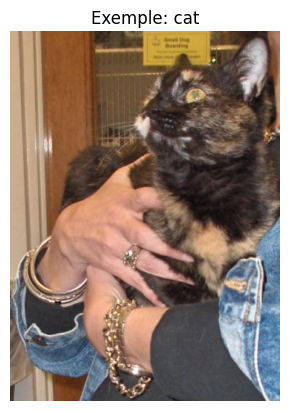

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


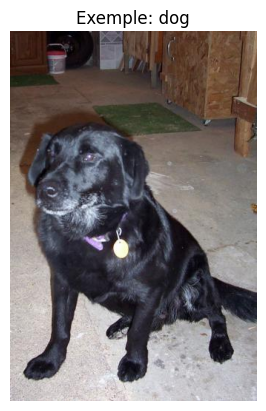

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9



Total d'images dans 'data/pets/train' : 19961

Total tailles d'images rencontrées : 6278


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


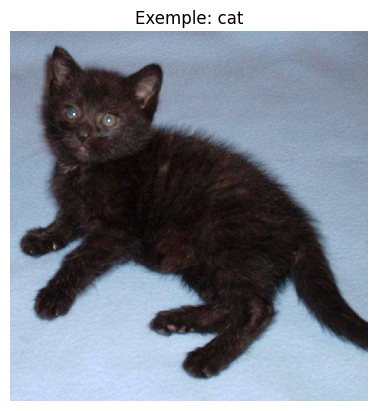

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


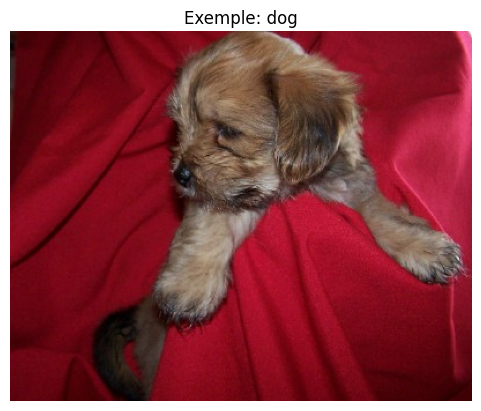


Total d'images dans 'data/pets/test' : 4985

Total tailles d'images rencontrées : 2091


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


In [2]:
def explore_images(data_dir, img_read_type: int):
    """
    Explore un répertoire d'images organisé par classe (sous-dossiers).

    - Affiche la première image de chaque sous-dossier.
    - Compte le nombre total d’images.
    - Recueille les tailles uniques des images rencontrées.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant les sous-dossiers d’images.
    img_read_type : int
        Mode de lecture OpenCV (ex. cv2.IMREAD_COLOR ou cv2.IMREAD_GRAYSCALE).
    """
    
    unique_shapes = set()
    displayed = set()
    total_images = 0

    for label_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible
                unique_shapes.add(img.shape)
                total_images += 1

                # Afficher la première image de chaque dossier
                if label_name not in displayed:
                    displayed.add(label_name)
                    plt.imshow(img if img_read_type == cv2.IMREAD_GRAYSCALE else cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Exemple: {label_name}")
                    plt.axis('off')
                    plt.show()

    print(f"\nTotal d'images dans '{data_dir}' : {total_images}")
    print(f"\nTotal tailles d'images rencontrées : {len(unique_shapes)}")


explore_images("data/pets/train", cv2.IMREAD_COLOR)
explore_images("data/pets/test", cv2.IMREAD_COLOR)

# 2. Chargement des images
___

In [3]:
def load_data(data_dir, img_read_type: int, target_size=(64, 64)):
    """
    Charge les images et les étiquettes depuis un répertoire structuré en sous-dossiers 'cat' et 'dog'.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant deux sous-dossiers : 'cat' et 'dog', chacun contenant les images correspondantes.
    img_read_type : int
        Mode de lecture des images pour OpenCV (par exemple cv2.IMREAD_GRAYSCALE ou cv2.IMREAD_COLOR).
    target_size : tuple (int, int), default=(64, 64)
        Dimensions finales souhaitées pour les images après redimensionnement.

    Returns
    -------
    X : 
        Tableau des images chargées et redimensionnées, converties en float32.
        La forme dépend du mode de lecture (grayscale ou couleur).
    
    y : 
        Tableau des labels (0 pour 'cat', 1 pour 'dog').
    """

    X = []
    y = []
    label_map = {'cat': 0, 'dog': 1}

    for label_name in ['cat', 'dog']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y


# Chargement des images en niveau de gris
X_train, y_train = load_data('data/pets/train', cv2.IMREAD_GRAYSCALE)
X_test, y_test = load_data('data/pets/test', cv2.IMREAD_GRAYSCALE)

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


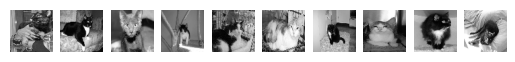

In [4]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

# 3. Preprocessing
___

Avant d’entraîner notre modèle, nous appliquons un prétraitement standard aux données :
- Conversion en float32 pour permettre des calculs plus précis pendant l’entraînement du modèle
- Normalisation des pixels pour ramener leur valeur dans l’intervalle [0, 1]
- Reshape pour aplatir chaque image (64×64) en un vecteur 1D de taille 4096

In [5]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255.0
X_test /= 255.0

X_train_reshape = X_train.reshape(X_train.shape[0], 64 * 64)
X_test_reshape = X_test.reshape(X_test.shape[0], 64 * 64)

# 4. Modélisation (MLP)
___

### 4.1 Préparation du modèle

In [6]:
model = models.Sequential([
    layers.Input(shape=(64 * 64,)),           
    layers.Dense(128, activation='relu'),  
    layers.Dense(64, activation='relu'),  
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',                           
    loss='binary_crossentropy',      
    metrics=['accuracy']                         
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,737 (2.03 MB)

 Trainable params: 532,737 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entraînement du modèle

In [7]:
history = model.fit(
    X_train_reshape, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshape, y_test)
)

Epoch 1/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5328 - loss: 0.7165 - val_accuracy: 0.5482 - val_loss: 0.6900
Epoch 2/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5723 - loss: 0.6792 - val_accuracy: 0.5725 - val_loss: 0.6798
Epoch 3/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5842 - loss: 0.6705 - val_accuracy: 0.5950 - val_loss: 0.6620
Epoch 4/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6021 - loss: 0.6605 - val_accuracy: 0.5936 - val_loss: 0.6635
Epoch 5/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6060 - loss: 0.6600 - val_accuracy: 0.5994 - val_loss: 0.6660
Epoch 6/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6138 - loss: 0.6555 - val_accuracy: 0.5962 - val_loss: 0.6660
Epoch 7/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6188 - loss: 0.6497 - val_accuracy: 0.5968 - val_loss: 0.6694
Epoch 8/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6170 - loss: 0.6509 - val_accuracy: 0.

### 4.3 Évaluation du modèle

Le modèle entraîné montre une performance assez faible. Nous sommes en présence d'un phénomène de `Underfitting` sur les données de validation,  cela s'explique notamment par l'usage du MLP en lui même. En effet, en utilisant un MPL nous faisons un mauvais choix d’architecture pour des images.

Les MLP ne captent pas les motifs spatiaux (formes, textures) dans les images. Ils prennent les pixels comme une liste brute de chiffres, sans exploiter la structure.

Résultat : 
- le modèle apprend un peu sur les données d’entraînement (73 %), mais n’arrive pas à généraliser, car il ne comprend pas les images.
- la validation accuracy est instable et basse (~57–60 %). Ce n’est pas un modèle qui surapprend, c’est un modèle mal adapté à la nature du problème.

Il convient d’envisager une architecture plus adaptée aux tâches de vision par ordinateur comme les CNN (Réseau de neurones convolutif).

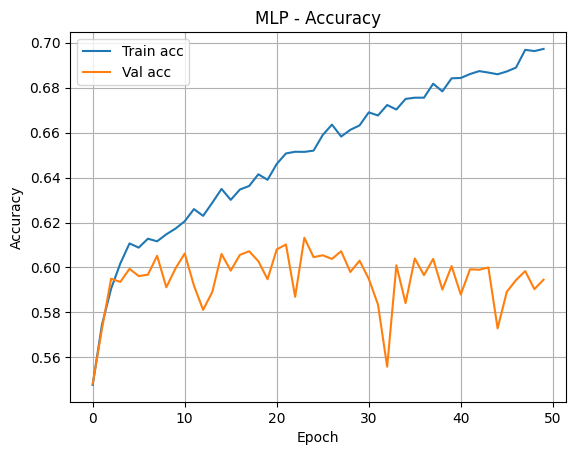

In [8]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("MLP - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 5. Modélisation (CNN)
___

In [9]:
# Chargement des images en conservant les 3 canaux (RGB)
X_train_cnn, y_train_cnn = load_data('data/pets/train', cv2.IMREAD_COLOR)
X_test_cnn, y_test_cnn = load_data('data/pets/test', cv2.IMREAD_COLOR)

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


### 5.1 Préparation du CNN

In [10]:
model_cnn = models.Sequential([
    # Entrée : images 64x64 en couleur (3 canaux)
    layers.Input(shape=(64, 64, 3)),

    # 1ère couche de convolution : 32 filtres 3x3, activation ReLU pour capter les motifs de base (bords, textures simples)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),  # Réduction de taille (downsampling)

    # 2e couche de convolution : 64 filtres pour capter des motifs un peu plus complexes
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),  # Réduction de taille (downsampling)

    # 3e couche de convolution : 128 filtres pour capter des formes encore plus abstraites
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),  # Réduction de taille (downsampling)

    # Passage d'une carte de caractéristiques 2D à un vecteur 1D
    layers.Flatten(),

    # Couche dense fully connected avec régularisation L2 pour empêcher les poids de devenir trop grands (contrôle la complexité)
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Dropout : désactive 50 % des neurones de la couche précédente à chaque batch pour améliorer la généralisation
    layers.Dropout(0.5),

    # Couche de sortie : 1 neurone avec activation sigmoïde pour classification binaire (chat ou chien)
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',                           
    loss='binary_crossentropy',      
    metrics=['accuracy']                         
)

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Entraînement du CNN

In [11]:
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cnn)
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5793 - loss: 1.9561 - val_accuracy: 0.6590 - val_loss: 0.7437
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.6860 - loss: 0.7036 - val_accuracy: 0.7444 - val_loss: 0.6163
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7538 - loss: 0.6115 - val_accuracy: 0.7866 - val_loss: 0.5550
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7919 - loss: 0.5533 - val_accuracy: 0.7785 - val_loss: 0.5507
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8089 - loss: 0.5082 - val_accuracy: 0.8028 - val_loss: 0.5290
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8298 - loss: 0.4813 - val_accuracy: 0.7974 - val_loss: 0.5320
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8446 - loss: 0.4576 - val_accuracy: 0.8221 - val_loss: 0.5018
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8631 - loss: 0.4190 - 

### 5.3 Évaluation du CNN

Le modèle CNN montre une excellente capacité d’apprentissage sur les données d’entraînement, avec une accuracy qui atteint progressivement plus de 94 %. Cela indique que le réseau parvient à bien ajuster ses paramètres pour reconnaître les images qu’il a vues pendant l’entraînement.

La courbe de validation est également bonne au début : elle progresse rapidement jusqu’à environ 85 %, ce qui montre une bonne généralisation initiale.
Cependant, on observe ensuite une stagnation, voire de légères oscillations, tandis que l’accuracy sur l’entraînement continue d’augmenter. Ce décalage indique un début de surapprentissage (overfitting) : le modèle commence à trop s’adapter aux données d’entraînement au détriment de sa capacité à généraliser.

Le modèle fonctionne bien dans l’ensemble, beaucoup mieux que le MLP, mais il pourrait être encore amélioré en :
- ajoutant une régularisation plus forte (Dropout, L2)
- appliquant de la data augmentation afin de travailler avec plus de données durant l'entraînement notamment
- ou en mettant en place un early stopping pour éviter de continuer l’entraînement au-delà du point optimal

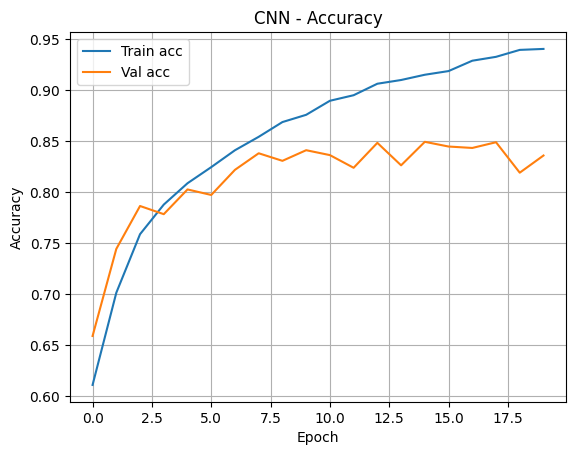

In [12]:
plt.plot(history_cnn.history['accuracy'], label='Train acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()